In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import numpy as np
import math
from sklearn.metrics import precision_recall_curve, average_precision_score

### Loading Dataset

In [2]:
df_1 = pd.read_csv("data/full_dataset/goemotions_1.csv")
df_2 = pd.read_csv("data/full_dataset/goemotions_2.csv")
df_3 = pd.read_csv("data/full_dataset/goemotions_3.csv")

Displaying first 5 rows from each dataset

In [3]:
df_1.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
df_2.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,We can hope,ee3o3ko,darkenseyreth,EdmontonOilers,t3_ag4r9j,t1_ee3mhad,1.547529e+09,62,False,0,...,0,0,1,0,0,0,0,0,0,0
1,Shhh don't give them the idea!,eebl3z7,BoinkBoinkEtAliae,MurderedByWords,t3_ah3o76,t1_eeb68lo,1.547777e+09,76,False,0,...,0,0,0,0,0,0,0,0,0,0
2,"Thank you so much, kind stranger. I really nee...",ed4fe9l,savageleaf,raisedbynarcissists,t3_abwh00,t1_ed4etbj,1.546482e+09,24,False,0,...,0,0,0,0,0,0,0,0,0,0
3,Ion know but it would be better for you to jus...,efavtdu,CADDiLLXC,darknet,t3_al4njw,t3_al4njw,1.548800e+09,62,False,0,...,0,0,0,0,0,0,0,0,0,1
4,I'm honestly surprised. We should have fallen ...,ee2imz2,CorporalThornberry,CollegeBasketball,t3_afxt6t,t1_ee22nyr,1.547497e+09,55,False,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_3.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,Worst ending ever! I won't spoil it but this o...,eee021b,tribaltrak,movies,t3_agxbsx,t3_agxbsx,1.547847e+09,42,False,0,...,0,0,0,0,0,0,0,0,0,0
1,Happy cake day u/sneakpeekbot!,ed00f1z,InfernicFuse,danganronpa,t3_abajdo,t1_eczoocj,1.546328e+09,24,False,0,...,0,0,0,0,0,0,0,0,0,0
2,Was he rejected because of his methodology or ...,ee1h5v1,OssToYouGoodSir,medicine,t3_aflo7s,t1_ee0v0vv,1.547464e+09,77,False,0,...,0,0,0,0,0,0,0,0,0,0
3,"thanks, I agree",eemi935,PMOFreeForever,NoFap,t3_ai7h09,t1_eelu54r,1.548088e+09,46,False,0,...,0,0,0,0,0,0,0,0,0,0
4,Why would you doubt it dumbass?,eduun99,ugliestman1,Tinder,t3_aejwne,t1_edumeal,1.547255e+09,36,False,0,...,0,0,0,0,0,0,0,0,0,0


Concanetating All Dataset into Singel DataFrame

In [6]:
df = pd.concat([df_1, df_2, df_3])
df.shape

(211225, 37)

Checking if the dataset contains NULL values or not

In [7]:
df.isnull().sum()

text                    0
id                      0
author                  0
subreddit               0
link_id                 0
parent_id               0
created_utc             0
rater_id                0
example_very_unclear    0
admiration              0
amusement               0
anger                   0
annoyance               0
approval                0
caring                  0
confusion               0
curiosity               0
desire                  0
disappointment          0
disapproval             0
disgust                 0
embarrassment           0
excitement              0
fear                    0
gratitude               0
grief                   0
joy                     0
love                    0
nervousness             0
optimism                0
pride                   0
realization             0
relief                  0
remorse                 0
sadness                 0
surprise                0
neutral                 0
dtype: int64

```The dataset does not contain any NULL values```

Checking if there is DUPLICATED data in the DataFrame

In [8]:
df.duplicated().sum()

np.int64(0)

```The dataset does not contain any DUPLICATED values```

DataFrame Information

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211225 entries, 0 to 71224
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   text                  211225 non-null  object 
 1   id                    211225 non-null  object 
 2   author                211225 non-null  object 
 3   subreddit             211225 non-null  object 
 4   link_id               211225 non-null  object 
 5   parent_id             211225 non-null  object 
 6   created_utc           211225 non-null  float64
 7   rater_id              211225 non-null  int64  
 8   example_very_unclear  211225 non-null  bool   
 9   admiration            211225 non-null  int64  
 10  amusement             211225 non-null  int64  
 11  anger                 211225 non-null  int64  
 12  annoyance             211225 non-null  int64  
 13  approval              211225 non-null  int64  
 14  caring                211225 non-null  int64  
 15  confus

### Aggregating Rater Responses
The raw dataset contains multiple entries for the same Reddit comment because each comment was reviewed by multiple independent raters.

In this step, the data is being grouped by unique ID and Text.

In [10]:
id_counts = df['id'].value_counts()
print(id_counts.unique())
print("The comments were reviewed by up to 5 different people")

[5 4 3 2 1]
The comments were reviewed by up to 5 different people


In [11]:
emotion_columns = df.columns[9:]

In [12]:
grouped_df = df.groupby(['id', 'text'])[emotion_columns].sum().reset_index()
grouped_df.shape

(58011, 30)

In [13]:
grouped_df.head()

,id,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,eczazk6,Fast as [NAME] will carry me. Seriously uptown...,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,eczb07q,You blew it. They played you like a fiddle.,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,eczb4bm,TL;DR No more Superbowls for [NAME]. Get ready...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,eczb527,So much time saved. Not.,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
4,eczb6r7,Emotes have a ridiculous amount of effort put ...,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,2


### Converting to Binary Labels
Converting the sums after grouping to binary values.

In [14]:
aggregated_df = grouped_df.copy()
for col in emotion_columns:
    aggregated_df[col] = (aggregated_df[col] > 0).astype(int)

In [15]:
aggregated_df.head()

,id,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,eczazk6,Fast as [NAME] will carry me. Seriously uptown...,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,eczb07q,You blew it. They played you like a fiddle.,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,eczb4bm,TL;DR No more Superbowls for [NAME]. Get ready...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,eczb527,So much time saved. Not.,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,eczb6r7,Emotes have a ridiculous amount of effort put ...,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,1


In [16]:
unwanted_cols = ['id']

In [17]:
master_df = aggregated_df.drop(columns=unwanted_cols)

In [18]:
master_df.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,Fast as [NAME] will carry me. Seriously uptown...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,You blew it. They played you like a fiddle.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,TL;DR No more Superbowls for [NAME]. Get ready...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,So much time saved. Not.,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Emotes have a ridiculous amount of effort put ...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1


In [19]:
master_df.shape

(58011, 29)

### Feature and Label Extraction
Defining Text/Documents as X(Feature) and Emotions as Y(Labels)

In [20]:
X = master_df['text']

In [21]:
X.head()

0    Fast as [NAME] will carry me. Seriously uptown...
1          You blew it. They played you like a fiddle.
2    TL;DR No more Superbowls for [NAME]. Get ready...
3                             So much time saved. Not.
4    Emotes have a ridiculous amount of effort put ...
Name: text, dtype: object

In [22]:
y = master_df.iloc[:,1:]

In [23]:
y.head()

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1


In [24]:
cols_num_rows = y.sum(axis=0).sort_values(ascending = False)

Text(0.5, 1.0, 'Emotion Categories x No. of Samples')

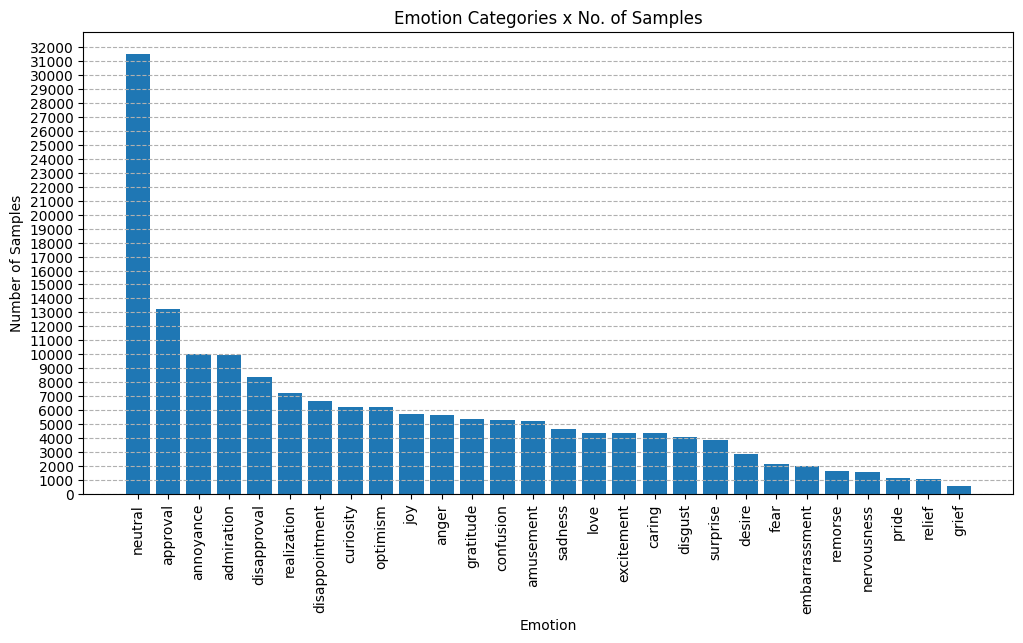

In [25]:
plt.figure(figsize=(12, 6))
plt.bar(cols_num_rows.index, cols_num_rows.values)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 33000, 1000))
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--')
plt.title("Emotion Categories x No. of Samples")

### Text Preprocessing

Normalizing texts:
- lowercase the text
- remove bracket bounded words[NAME], [RELIGION]
- remove technical pronounciation, except: '!', '?'
- remove URL
- remove whitespaces

In [26]:
def clean_text(text):
    # lowercase text
    text = text.lower()
    # remove text that are inside brackets eg: [NAME], [RELIGION]
    text = re.sub(r'\[.*?\]', '', text)
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # remove technical punctuation characters like ""#$%&\'()*+,-./:;<=>@\\^_`{|}~"
    technical_punct = '"#$%&\'()*+,-./:;<=>@\\^_`{|}~'
    text = text.translate(str.maketrans(technical_punct, ' ' * len(technical_punct)))
    # remove white spaces
    text = " ".join(text.split())
    return text

In [27]:
X = X.apply(clean_text)

In [28]:
X.head()

0    fast as will carry me seriously uptown to down...
1            you blew it they played you like a fiddle
2    tl dr no more superbowls for get ready for ano...
3                               so much time saved not
4    emotes have a ridiculous amount of effort put ...
Name: text, dtype: object

### Spliting Dataset
Spliting data set into 70% for training and 15% each for Cross Validation and Testing

In [29]:
type(X), type(y)

(pandas.core.series.Series, pandas.core.frame.DataFrame)

In [30]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [32]:
print(f"Training samples  : {len(X_train)}")  
print(f"Validation samples: {len(X_val)}")     
print(f"Test samples      : {len(X_test)}")

Training samples  : 46408
Validation samples: 5802
Test samples      : 5801


### Tokenization and Vectorization
For tokenization, BERT Tokenizer is used. 

In [33]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [34]:
def tokenize_data(texts, max_length=64):
    return tokenizer(texts.tolist(), 
                     add_special_tokens=True, 
                     max_length=max_length, 
                     padding='max_length', 
                     truncation=True, 
                     return_attention_mask=True, 
                     return_tensors='pt')

In [35]:
train_encodings = tokenize_data(X_train)
val_encodings = tokenize_data(X_val)
test_encodings = tokenize_data(X_test)

In [36]:
train_encodings['input_ids']

tensor([[  101,  2644,  2725,  ...,     0,     0,     0],
        [  101,  5791,  2025,  ...,     0,     0,     0],
        [  101,  1045,  2064,  ...,     0,     0,     0],
        ...,
        [  101,  2033,  2205,  ...,     0,     0,     0],
        [  101,  8909,  2243,  ...,     0,     0,     0],
        [  101, 13207,  5324,  ...,     0,     0,     0]])

In [37]:
train_encodings['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [38]:
X_train_ids = train_encodings['input_ids']
X_train_mask = train_encodings['attention_mask']

X_val_ids = val_encodings['input_ids']
X_val_mask = val_encodings['attention_mask']

X_test_ids = test_encodings['input_ids']
X_test_mask = test_encodings['attention_mask']

In [39]:
X_train_ids.shape, X_train_mask.shape

(torch.Size([46408, 64]), torch.Size([46408, 64]))

### Converting to pytorch tensors and loading to TensorDataset

In [40]:
y_train_tensor = torch.tensor(y_train.values).float()
y_val_tensor = torch.tensor(y_val.values).float()
y_test_tensor = torch.tensor(y_test.values).float()

In [41]:
y_train_tensor.shape

torch.Size([46408, 28])

In [42]:
train_dataset = TensorDataset(X_train_ids, X_train_mask, y_train_tensor)
val_dataset = TensorDataset(X_val_ids, X_val_mask, y_val_tensor)
test_dataset = TensorDataset(X_test_ids, X_test_mask, y_test_tensor)

In [43]:
train_dataset[0]

(tensor([ 101, 2644, 2725, 6881, 2477,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]),
 tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [44]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader= DataLoader(test_dataset, batch_size=batch_size)

### Defining LSTM Model

In [45]:
class GoEmotionLSTM(nn.Module):
    def __init__(self, vocab_size = 30522, embedding_dim = 128, hidden_dim = 256, output_dim=28):
        super(GoEmotionLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional = True, 
                            dropout=0.3, num_layers = 3)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden_state, cell_state) = self.lstm(embedded)
        # output = concatenation of last hidden state of both direction, Forward and Backward
        out = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1)
        return self.fc(out)
    
    # def forward(self, x):
    #     embedded = self.embedding(x)
    #     lstm_out, (h_n, c_n) = self.lstm(embedded)
    #     last_hidden = h_n.squeeze(0)
    #     logits = self.fc(last_hidden) 
    #     return logits

Selecting device to run model

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [47]:
model = GoEmotionLSTM(vocab_size=30522, embedding_dim=128, hidden_dim=256, output_dim=28).to(device)

In [48]:
weights = torch.ones([28]) * 5.0 
criterion = nn.BCEWithLogitsLoss(pos_weight=weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [49]:
def plot_result(train_loss, val_loss):
    epochs_range = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs_range, train_loss, label="Train Loss", marker='o')
    plt.plot(epochs_range, val_loss, label="Validation Loss", marker='o')
    
    plt.title("Loss vs Epochs Graph")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

def plot_pr_curve(y_true, y_probs):
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_probs.ravel())
    avg_precision = average_precision_score(y_true, y_probs, average="micro")

    plt.figure(figsize=(7, 5))
    plt.step(recall, precision, where='post', color='green', label=f'Micro-avg AP = {avg_precision:.2f}')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='green')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Multi-label)')
    plt.legend()
    plt.grid(True)
    plt.show()

### Training Bi-LSTM Model

Epoch [1/20]
Train Loss: 0.7488 | Val Loss: 0.6905
Val Macro F1: 0.2617
Best model saved.
Epoch [2/20]
Train Loss: 0.6700 | Val Loss: 0.6476
Val Macro F1: 0.3224
Best model saved.
Epoch [3/20]
Train Loss: 0.6367 | Val Loss: 0.6312
Val Macro F1: 0.3423
Best model saved.
Epoch [4/20]
Train Loss: 0.6125 | Val Loss: 0.6171
Val Macro F1: 0.3612
Best model saved.
Epoch [5/20]
Train Loss: 0.5931 | Val Loss: 0.6101
Val Macro F1: 0.3698
Best model saved.
Epoch [6/20]
Train Loss: 0.5756 | Val Loss: 0.6027
Val Macro F1: 0.3826
Best model saved.
Epoch [7/20]
Train Loss: 0.5597 | Val Loss: 0.5979
Val Macro F1: 0.3933
Best model saved.
Epoch [8/20]
Train Loss: 0.5447 | Val Loss: 0.5940
Val Macro F1: 0.3947
Best model saved.
Epoch [9/20]
Train Loss: 0.5306 | Val Loss: 0.5943
Val Macro F1: 0.3967
Best model saved.
Epoch [10/20]
Train Loss: 0.5163 | Val Loss: 0.5937
Val Macro F1: 0.4011
Best model saved.
Epoch [11/20]
Train Loss: 0.5030 | Val Loss: 0.6001
Val Macro F1: 0.4049
Best model saved.
Epoch [1

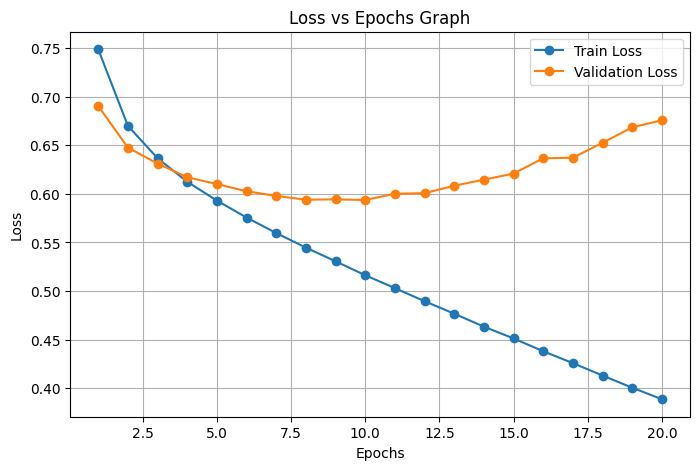

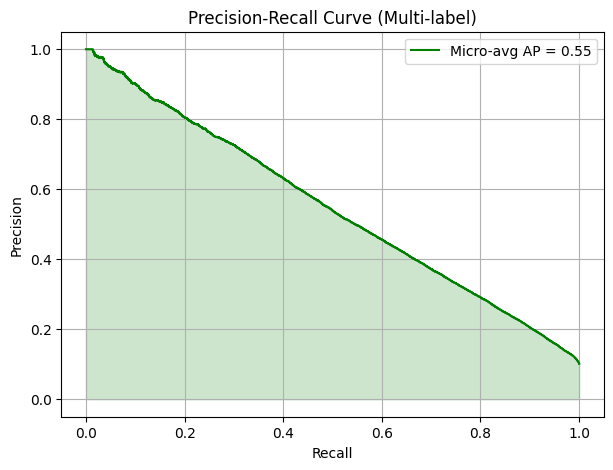

In [50]:
epochs = 20
best_val_f1 = 0.0

train_loss_history = []
validation_loss_history = []
all_val_labels = []
all_val_probs = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    
    for batch in train_loader:
        #move data to GPU
        input_ids, _, labels = [b.to(device) for b in batch]

        # Reseting gradients to 0
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids)
        
        # Loss Calculation
        loss = criterion(outputs, labels)
        
        # Backward Pass
        loss.backward()
        
        # Update Model weights
        optimizer.step()

        # Accumulate the loss
        total_train_loss += loss.item()

    # --- VALIDATION PHASE ---
    model.eval()
    epoch_preds = []
    epoch_labels = []
    epoch_probs = []
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, _, labels = [b.to(device) for b in batch]
            
            logits = model(input_ids)
            val_loss = criterion(logits, labels)
            total_val_loss += val_loss.item()

            # Capture probabilities for PR Graph
            probs = torch.sigmoid(logits).cpu().numpy()
            epoch_probs.append(probs)
            epoch_labels.append(labels.cpu().numpy())
            
            # Binary predictions for F1
            preds = (probs > 0.5).astype(int)
            epoch_preds.append(preds)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_loss_history.append(avg_train_loss)
    validation_loss_history.append(avg_val_loss)
    
    current_val_f1 = f1_score(np.vstack(epoch_labels), np.vstack(epoch_preds), average='macro', zero_division=0)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Val Macro F1: {current_val_f1:.4f}")

    # --- SAVE BEST MODEL ---
    if current_val_f1 > best_val_f1:
        best_val_f1 = current_val_f1
        torch.save(model.state_dict(), 'best_lstm_goemotion.pt')
        print("Best model saved.")
        
all_val_labels = np.vstack(epoch_labels)
all_val_probs = np.vstack(epoch_probs)
print(f"\nTraining Complete! Highest Validation F1: {best_val_f1:.4f}")
plot_result(train_loss_history, validation_loss_history)
plot_pr_curve(all_val_labels, all_val_probs)

### Defining Seq2Seq Model

In [51]:
class GoEmotionSeq2Seq(nn.Module):
    def __init__(self, vocab_size = 30522, embedding_dim = 128, hidden_dim = 256, output_dim=28):
        super(GoEmotionSeq2Seq, self).__init__()
        # BERT Embedding 
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Encoder with 3-layer Bi-LSTM
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional = True, 
                            dropout=0.3, num_layers = 3)
        # Context vectors from encoder layer
        self.context_vector = hidden_dim*2
        # Decoder
        self.decoder = nn.LSTM(self.context_vector, self.context_vector, batch_first= True)
        
        self.fc = nn.Linear(self.context_vector, output_dim)
        self.dropout=nn.Dropout(0.3)

    def forward(self, x):
        embedded = self.embedding(x)

        # Outputs of the Encoder
        _, (hidden_state, cell_state) = self.encoder(embedded)

        # Last Cell and Hidden States as Context Vectors 
        hs_forward = hidden_state[-2, :, :]
        hs_backward = hidden_state[-1, :, :]
        cs_forward = cell_state[-2, :, :]
        cs_backward = cell_state[-1, :, :]

        # Concatenation Hidden States and Cell States for Decoder 
        context_hs = torch.cat((hs_forward, hs_backward), dim=1).unsqueeze(1)
        context_cs = torch.cat((cs_forward, cs_backward), dim=1).unsqueeze(1)

        # Output from Decoder
        decoder_out, _ = self.decoder(context_hs, (context_hs.transpose(0,1), context_cs.transpose(0,1)))
        logits = self.fc(self.dropout(decoder_out.squeeze(1)))
        return logits

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [53]:
model = GoEmotionSeq2Seq().to(device)

In [54]:
weights = torch.ones([28]) * 5.0 
criterion = nn.BCEWithLogitsLoss(pos_weight=weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Epoch [1/20]
Train Loss: 0.7554 | Val Loss: 0.6997
Val Macro F1: 0.2351
Best model saved.
Epoch [2/20]
Train Loss: 0.6804 | Val Loss: 0.6576
Val Macro F1: 0.3077
Best model saved.
Epoch [3/20]
Train Loss: 0.6438 | Val Loss: 0.6340
Val Macro F1: 0.3457
Best model saved.
Epoch [4/20]
Train Loss: 0.6181 | Val Loss: 0.6187
Val Macro F1: 0.3555
Best model saved.
Epoch [5/20]
Train Loss: 0.5979 | Val Loss: 0.6112
Val Macro F1: 0.3699
Best model saved.
Epoch [6/20]
Train Loss: 0.5803 | Val Loss: 0.6026
Val Macro F1: 0.3795
Best model saved.
Epoch [7/20]
Train Loss: 0.5647 | Val Loss: 0.5960
Val Macro F1: 0.3893
Best model saved.
Epoch [8/20]
Train Loss: 0.5502 | Val Loss: 0.5966
Val Macro F1: 0.3894
Best model saved.
Epoch [9/20]
Train Loss: 0.5372 | Val Loss: 0.5925
Val Macro F1: 0.3926
Best model saved.
Epoch [10/20]
Train Loss: 0.5245 | Val Loss: 0.5932
Val Macro F1: 0.4002
Best model saved.
Epoch [11/20]
Train Loss: 0.5113 | Val Loss: 0.5975
Val Macro F1: 0.4078
Best model saved.
Epoch [1

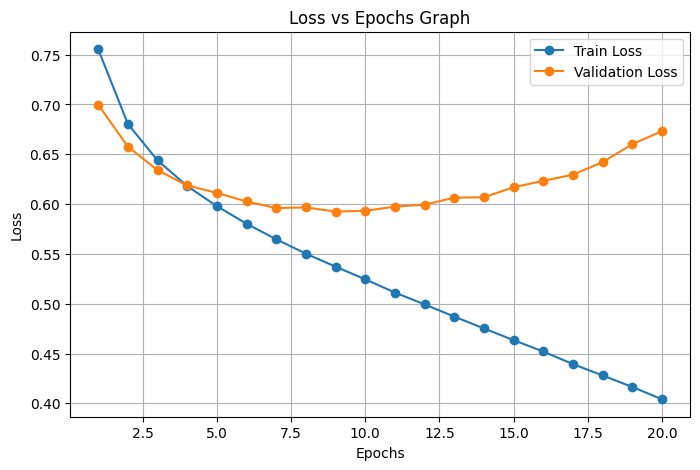

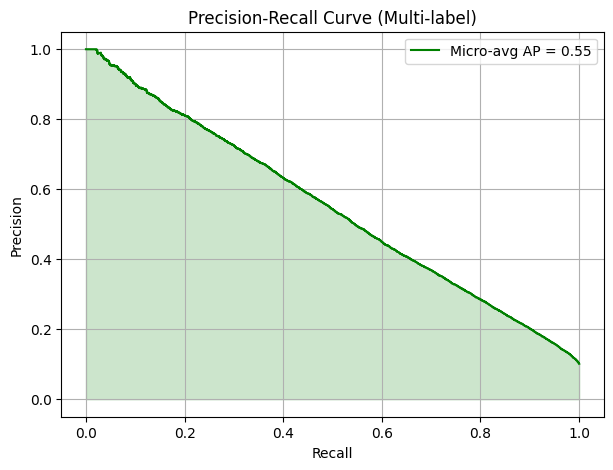

In [55]:
epochs = 20
best_val_f1 = 0.0

train_loss_history = []
validation_loss_history = []
all_val_labels = []
all_val_probs = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    
    for batch in train_loader:
        #move data to GPU
        input_ids, _, labels = [b.to(device) for b in batch]

        # Reseting gradients to 0
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids)
        
        # Loss Calculation
        loss = criterion(outputs, labels)
        
        # Backward Pass
        loss.backward()
        
        # Update Model weights
        optimizer.step()

        # Accumulate the loss
        total_train_loss += loss.item()
    
    # --- VALIDATION PHASE ---
    model.eval()
    epoch_preds = []
    epoch_labels = []
    epoch_probs = []
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, _, labels = [b.to(device) for b in batch]
            
            logits = model(input_ids)
            val_loss = criterion(logits, labels)
            total_val_loss += val_loss.item()

            # Capture probabilities for PR Graph
            probs = torch.sigmoid(logits).cpu().numpy()
            epoch_probs.append(probs)
            epoch_labels.append(labels.cpu().numpy())
            
            # Binary predictions for F1
            preds = (probs > 0.5).astype(int)
            epoch_preds.append(preds)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_loss_history.append(avg_train_loss)
    validation_loss_history.append(avg_val_loss)
    
    current_val_f1 = f1_score(np.vstack(epoch_labels), np.vstack(epoch_preds), average='macro', zero_division=0)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Val Macro F1: {current_val_f1:.4f}")

    # --- SAVE BEST MODEL ---
    if current_val_f1 > best_val_f1:
        best_val_f1 = current_val_f1
        torch.save(model.state_dict(), 'best_seq2seq_goemotion.pt')
        print("Best model saved.")
        
all_val_labels = np.vstack(epoch_labels)
all_val_probs = np.vstack(epoch_probs)
print(f"\nTraining Complete! Highest Validation F1: {best_val_f1:.4f}")
plot_result(train_loss_history, validation_loss_history)
plot_pr_curve(all_val_labels, all_val_probs)

### Transformer Model

In [56]:
class GoEmotionTransformer(nn.Module):
    def __init__(self, vocab_size=30522, embed_dim=128, n_heads=8, n_layers=3, output_dim=28, max_len=64):
        super(GoEmotionTransformer, self).__init__()
        
        # 1. Token & Positional Embeddings
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = nn.Parameter(torch.zeros(1, max_len, embed_dim))
        
        # 2. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=n_heads, 
            dim_feedforward=embed_dim * 4, 
            dropout=0.1, 
            batch_first=True,
            activation='gelu'
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # 3. Classification Head
        self.dropout = nn.Dropout(0.3)
        self.pre_classifier = nn.Linear(embed_dim, embed_dim)
        self.classifier = nn.Linear(embed_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, mask=None):
        # x shape: [batch_size, seq_len]
        batch_size, seq_len = x.size()
        
        # Add embeddings and positions
        embeddings = self.embedding(x) + self.pos_embedding[:, :seq_len, :]
        
        # Pass through Transformer layers
        hidden_states = self.transformer_encoder(embeddings, src_key_padding_mask=mask)
        
        # 4. BERT-style Pooling
        pooled_output = hidden_states[:, 0, :] 
        
        # Additional dense layer before output 
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = self.relu(pooled_output)
        
        # Final Logits
        logits = self.classifier(self.dropout(pooled_output))
        return logits

In [57]:
model = GoEmotionTransformer().to(device)

weights = torch.ones([28]) * 2.0 
criterion = nn.BCEWithLogitsLoss(pos_weight=weights.to(device))

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

Epoch [1/20]
Train Loss: 0.4536 | Val Loss: 0.3996
Val Macro F1: 0.1831
Best model saved.
Epoch [2/20]
Train Loss: 0.3950 | Val Loss: 0.3711
Val Macro F1: 0.2722
Best model saved.
Epoch [3/20]
Train Loss: 0.3751 | Val Loss: 0.3611
Val Macro F1: 0.3184
Best model saved.
Epoch [4/20]
Train Loss: 0.3651 | Val Loss: 0.3545
Val Macro F1: 0.3287
Best model saved.
Epoch [5/20]
Train Loss: 0.3577 | Val Loss: 0.3503
Val Macro F1: 0.3378
Best model saved.
Epoch [6/20]
Train Loss: 0.3513 | Val Loss: 0.3464
Val Macro F1: 0.3543
Best model saved.
Epoch [7/20]
Train Loss: 0.3459 | Val Loss: 0.3443
Val Macro F1: 0.3618
Best model saved.
Epoch [8/20]
Train Loss: 0.3418 | Val Loss: 0.3419
Val Macro F1: 0.3737
Best model saved.
Epoch [9/20]
Train Loss: 0.3377 | Val Loss: 0.3418
Val Macro F1: 0.3793
Best model saved.
Epoch [10/20]
Train Loss: 0.3336 | Val Loss: 0.3398
Val Macro F1: 0.3854
Best model saved.
Epoch [11/20]
Train Loss: 0.3300 | Val Loss: 0.3394
Val Macro F1: 0.3929
Best model saved.
Epoch [1

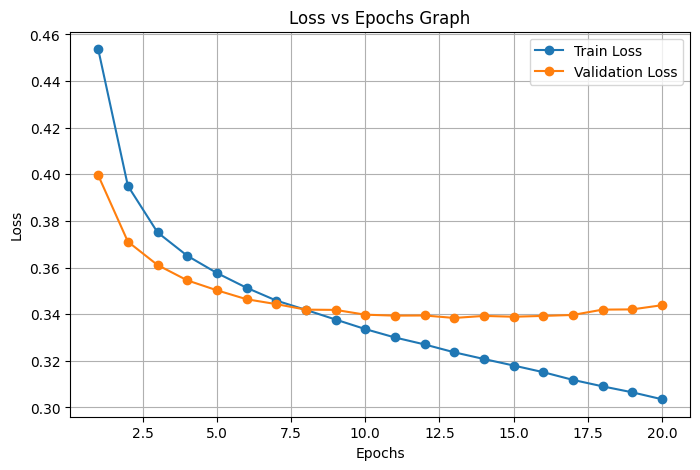

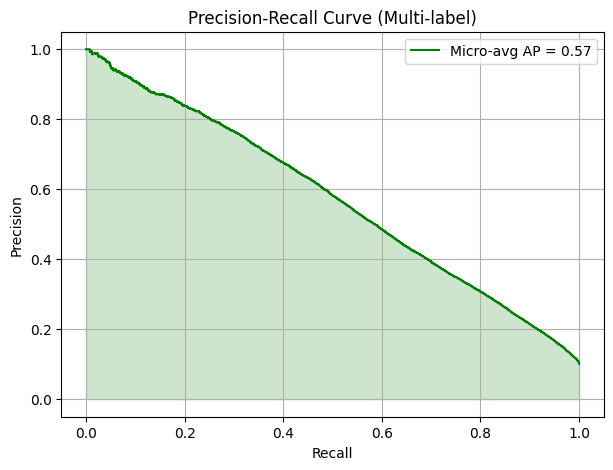

In [58]:
epochs = 20
best_val_f1 = 0.0

train_loss_history = []
validation_loss_history = []
all_val_labels = []
all_val_probs = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    
    for batch in train_loader:
        #move data to GPU
        input_ids, _, labels = [b.to(device) for b in batch]

        # Reseting gradients to 0
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids)
        
        # Loss Calculation
        loss = criterion(outputs, labels)
        
        # Backward Pass
        loss.backward()
        
        # Update Model weights
        optimizer.step()

        # Accumulate the loss
        total_train_loss += loss.item()

    # --- VALIDATION PHASE ---
    model.eval()
    epoch_preds = []
    epoch_labels = []
    epoch_probs = []
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, _, labels = [b.to(device) for b in batch]
            
            logits = model(input_ids)
            val_loss = criterion(logits, labels)
            total_val_loss += val_loss.item()

            # Capture probabilities for PR Graph
            probs = torch.sigmoid(logits).cpu().numpy()
            epoch_probs.append(probs)
            epoch_labels.append(labels.cpu().numpy())
            
            # Binary predictions for F1
            preds = (probs > 0.5).astype(int)
            epoch_preds.append(preds)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_loss_history.append(avg_train_loss)
    validation_loss_history.append(avg_val_loss)
    
    current_val_f1 = f1_score(np.vstack(epoch_labels), np.vstack(epoch_preds), average='macro', zero_division=0)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Val Macro F1: {current_val_f1:.4f}")

    # --- SAVE BEST MODEL ---
    if current_val_f1 > best_val_f1:
        best_val_f1 = current_val_f1
        torch.save(model.state_dict(), 'best_transformer_goemotion.pt')
        print("Best model saved.")
        
all_val_labels = np.vstack(epoch_labels)
all_val_probs = np.vstack(epoch_probs)
print(f"\nTraining Complete! Highest Validation F1: {best_val_f1:.4f}")
plot_result(train_loss_history, validation_loss_history)
plot_pr_curve(all_val_labels, all_val_probs)